## Лабораторная работа № 3
### Андрюшина Мария, 932001
### Задание №1
### Бинарный классификатор

Подключаем Google Диск:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Импорт библиотек

In [23]:
import cv2
import os
import random
import tensorflow as tf
import numpy as np
from shutil import copyfile
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from sklearn.metrics import accuracy_score, classification_report

### Работа с данными

In [ ]:
paths = ['/content/drive/MyDrive/Tomato__Tomato_YellowLeaf__Curl_Virus', '/content/drive/MyDrive/Tomato_healthy', '/content/drive/MyDrive/Tomato_Septoria_leaf_spot']
classes = ['Tomato Curl Virus', 'Tomato Healthy', 'Tomato Septoria']

for i, path in enumerate(paths):
    print(f'В папке {classes[i]} {len(os.listdir(path))} изображений')

В папке Tomato Curl Virus 3219 изображений
В папке Tomato Healthy 1591 изображений
В папке Tomato Septoria 1771 изображений


Создаём папки для разделённых данных

In [ ]:
root = '/content/drive/MyDrive/binary'
os.makedirs(os.path.join(root, 'train'))
os.makedirs(os.path.join(root, 'valid'))
os.makedirs(os.path.join(root, 'test'))
os.makedirs(os.path.join(root, 'train/Tomato_Curl_Virus'))
os.makedirs(os.path.join(root, 'train/Tomato_Healthy'))
os.makedirs(os.path.join(root, 'valid/Tomato_Curl_Virus'))
os.makedirs(os.path.join(root, 'valid/Tomato_Healthy'))
os.makedirs(os.path.join(root, 'test/Tomato_Curl_Virus'))
os.makedirs(os.path.join(root, 'test/Tomato_Healthy'))

Функция для разделения данных на тренировочную, валидационную и тестовую выборки:

In [ ]:
def split_train_val_test(source, train, valid, test, train_split, valid_split, test_split):
    filtered_files = []
    for file_name in os.listdir(source):
        file_path = os.path.join(source, file_name)

        if os.path.getsize(file_path):
            filtered_files.append(file_name)

    random_files = random.sample(filtered_files, len(filtered_files))
    split_train = int(train_split * len(filtered_files))
    split_val = split_train + int(valid_split * len(filtered_files))
    split_test = split_val + int(test_split * len(filtered_files))

    training_files = random_files[:split_train]
    val_files = random_files[split_train:split_val]
    test_files = random_files[split_val:]

    for file_name in training_files:
        copyfile(os.path.join(source, file_name), os.path.join(train, file_name))

    for file_name in val_files:
        copyfile(os.path.join(source, file_name), os.path.join(valid, file_name))

    for file_name in test_files:
        copyfile(os.path.join(source, file_name), os.path.join(test, file_name))

Разделим датасет на три части: тренировочную (70%), тестовую (20%) и валидационную (10%).

In [ ]:
split_train_size = .7
split_val_size = .1
split_test_size = .2

split_train_val_test(paths[0], '/content/drive/MyDrive/binary/train/Tomato_Curl_Virus',
                     '/content/drive/MyDrive/binary/valid/Tomato_Curl_Virus', '/content/drive/MyDrive/binary/test/Tomato_Curl_Virus',
                     split_train_size, split_val_size, split_test_size)
split_train_val_test(paths[1], '/content/drive/MyDrive/binary/train/Tomato_Healthy',
                     '/content/drive/MyDrive/binary/valid/Tomato_Healthy', '/content/drive/MyDrive/binary/test/Tomato_Healthy',
                     split_train_size, split_val_size, split_test_size)
print('Train')
print(f"{len(os.listdir('/content/drive/MyDrive/binary/train/Tomato_Curl_Virus'))} изображений в {classes[0]}")
print(f"{len(os.listdir('/content/drive/MyDrive/binary/train/Tomato_Healthy'))} изображений в {classes[1]}")
print('Valid')
print(f"{len(os.listdir('/content/drive/MyDrive/binary/valid/Tomato_Curl_Virus'))} изображений в {classes[0]}")
print(f"{len(os.listdir('/content/drive/MyDrive/binary/valid/Tomato_Healthy'))} изображений в {classes[1]}")
print('Test')
print(f"{len(os.listdir('/content/drive/MyDrive/binary/test/Tomato_Curl_Virus'))} изображений в {classes[0]}")
print(f"{len(os.listdir('/content/drive/MyDrive/binary/test/Tomato_Healthy'))} изображений в {classes[1]}")

svn-r6Yb5c .
Train
2252 изображений в Tomato Curl Virus
1113 изображений в Tomato Healthy
Valid
321 изображений в Tomato Curl Virus
159 изображений в Tomato Healthy
Test
645 изображений в Tomato Curl Virus
319 изображений в Tomato Healthy


Генерация данных:

In [3]:
def generate_train_val_test_base(train_path, valid_path, test_path):
    train_data_gen = ImageDataGenerator(rescale = 1.0 / 255.)
    valid_data_gen = ImageDataGenerator(rescale = 1.0 / 255.)
    test_data_gen = ImageDataGenerator(rescale = 1.0 / 255.)

    train_gen = train_data_gen.flow_from_directory(directory = train_path, batch_size = 64,
                                                   class_mode = 'categorical', target_size = (256, 256))
    valid_gen = valid_data_gen.flow_from_directory(directory = valid_path, batch_size = 64,
                                                   class_mode = 'categorical', target_size = (256, 256))
    test_gen = test_data_gen.flow_from_directory(directory = test_path, batch_size = 64,
                                                 class_mode = 'categorical', target_size = (256, 256))

    return train_gen, valid_gen, test_gen

In [ ]:
Train_base, Valid_base, Test_base = generate_train_val_test_base('/content/drive/MyDrive/binary/train', '/content/drive/MyDrive/binary/valid', '/content/drive/MyDrive/binary/test')

Found 3365 images belonging to 2 classes.
Found 480 images belonging to 2 classes.
Found 964 images belonging to 2 classes.


### Создание моделей
#### Base Model

In [ ]:
binary_base_model = tf.keras.models.Sequential([
        layers.Conv2D(8, kernel_size=5, activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(16, kernel_size=5, activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(32, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(2, activation="softmax")
    ])
binary_base_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 84, 84, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 80, 80, 16)        3216      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 26, 26, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 8, 8, 32)       

In [ ]:
binary_base_model.compile(keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Зададим число эпох, равное 20:

In [ ]:
binary_base_model_history = binary_base_model.fit(Train_base, epochs=20, validation_data = Valid_base, callbacks = callbacks_list, verbose=1)

Epoch 1/20
53/53 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.8140
Epoch 1: val_accuracy improved from -inf to 0.96250, saving model to best_model.hdf5
53/53 [==============================] - 205s 4s/step - loss: 0.3923 - accuracy: 0.8140 - val_loss: 0.1339 - val_accuracy: 0.9625
Epoch 2/20
53/53 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9694
Epoch 2: val_accuracy improved from 0.96250 to 0.98333, saving model to best_model.hdf5
53/53 [==============================] - 207s 4s/step - loss: 0.0924 - accuracy: 0.9694 - val_loss: 0.0656 - val_accuracy: 0.9833
Epoch 3/20
53/53 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9798
Epoch 3: val_accuracy did not improve from 0.98333
53/53 [==============================] - 213s 4s/step - loss: 0.0637 - accuracy: 0.9798 - val_loss: 0.0574 - val_accuracy: 0.9812
Epoch 4/20
53/53 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9887
Epoch 4: v

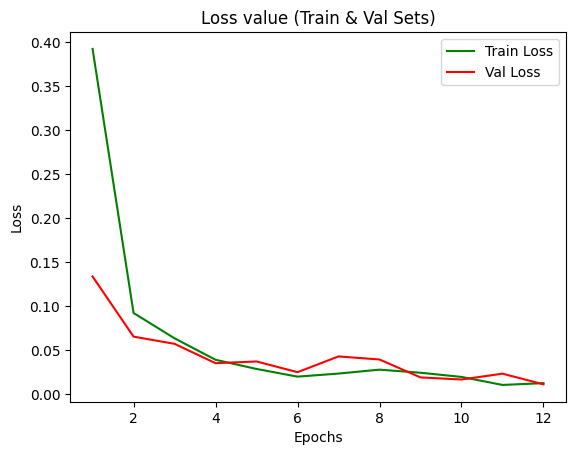

In [ ]:
loss_function = binary_base_model_history.history['loss']
val_loss_function = binary_base_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

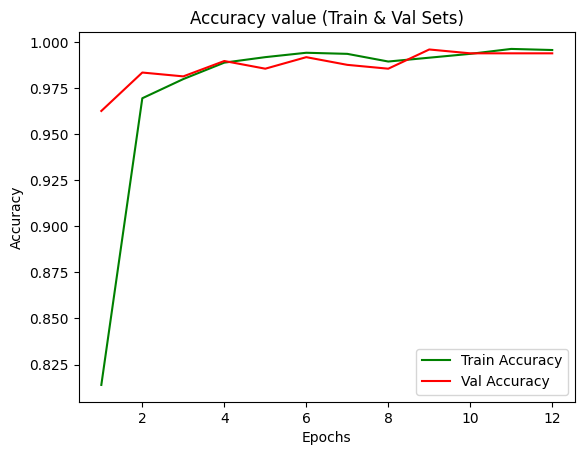

In [ ]:
accuracy_function = binary_base_model_history.history['accuracy']
val_accuracy_function = binary_base_model_history.history['val_accuracy']

epochs=range(1,len(loss_function)+1)

plt.title('Accuracy value (Train & Val Sets)')
plt.plot(epochs,accuracy_function,color='green',label='Train Accuracy')
plt.plot(epochs,val_accuracy_function,color='red',label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
preds = binary_base_model.predict(Test_base)

16/16 [==============================] - 23s 1s/step


In [ ]:
truth = Test_base.labels
binary_preds = np.argmax(preds, axis=1)

In [ ]:
print(classification_report(truth, binary_preds))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       645
           1       0.27      0.28      0.28       319

    accuracy                           0.52       964
   macro avg       0.46      0.46      0.46       964
weighted avg       0.52      0.52      0.52       964



Посмотрим, как модель предсказывает зараженные листья (класс 0) и здоровые (класс 1):

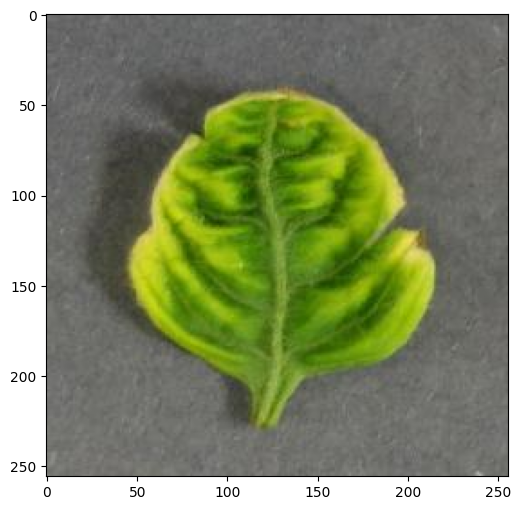

1/1 [==============================] - 0s 346ms/step
Предсказанный класс: [0]


In [ ]:
test_img = '/content/drive/MyDrive/binary/test/Tomato_Curl_Virus/02affd71-1fe6-48f7-bef4-3d5a59ec7814___UF.GRC_YLCV_Lab 01517.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = binary_base_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

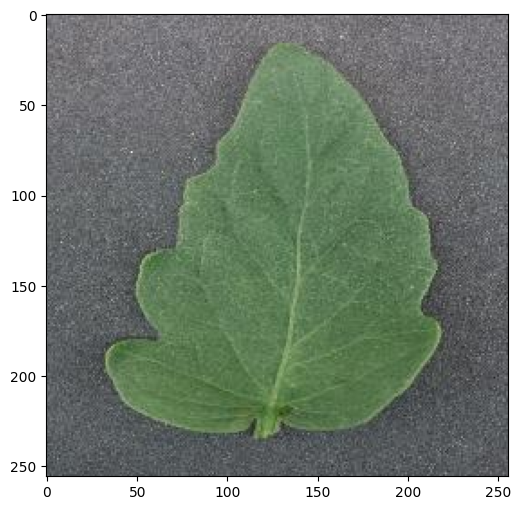

1/1 [==============================] - 0s 72ms/step
Предсказанный класс: [1]


In [ ]:
test_img = '/content/drive/MyDrive/binary/test/Tomato_Healthy/7f5c8018-c4c3-4471-aa30-defe910ea3d9___GH_HL Leaf 444.1.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = binary_base_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

#### Second Model

Генерация данных с аугментацией:

In [4]:
def generate_train_val_test(train_path, valid_path, test_path):
    train_data_gen = ImageDataGenerator(rescale = 1.0 / 255., rotation_range = 20, width_shift_range = .2,
                                        height_shift_range = .2, fill_mode = 'nearest')
    valid_data_gen = ImageDataGenerator(rescale = 1.0 / 255., rotation_range = 20, width_shift_range = .2,
                                       height_shift_range = .2, fill_mode = 'nearest')
    test_data_gen = ImageDataGenerator(rescale = 1.0 / 255., rotation_range = 40, width_shift_range = .2,
                                       height_shift_range = .2, fill_mode = 'nearest')

    train_gen = train_data_gen.flow_from_directory(directory = train_path, batch_size = 64,
                                                   class_mode = 'categorical', target_size = (256, 256))
    valid_gen = valid_data_gen.flow_from_directory(directory = valid_path, batch_size = 64,
                                                   class_mode = 'categorical', target_size = (256, 256))
    test_gen = test_data_gen.flow_from_directory(directory = test_path, batch_size = 64,
                                                 class_mode = 'categorical', target_size = (256, 256))

    return train_gen, valid_gen, test_gen

In [ ]:
Train, Valid, Test = generate_train_val_test('/content/drive/MyDrive/binary/train', '/content/drive/MyDrive/binary/valid', '/content/drive/MyDrive/binary/test')

Found 3365 images belonging to 2 classes.
Found 480 images belonging to 2 classes.
Found 964 images belonging to 2 classes.


Создание второй модели:

In [ ]:
binary_model = tf.keras.models.Sequential([
        layers.Conv2D(8, kernel_size=5, activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(16, kernel_size=5, activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(32, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(2, activation="softmax")
    ])
binary_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 84, 84, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 80, 80, 16)        3216      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 26, 26, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 8, 8, 32)       

In [ ]:
binary_model.compile(keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 4, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Зададим число эпох, равное 20:

In [ ]:
binary_model_history = binary_model.fit(Train, epochs=20, validation_data = Valid, callbacks = callbacks_list, verbose=1)

Epoch 1/20
53/53 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8125
Epoch 1: val_accuracy improved from -inf to 0.96250, saving model to best_model.hdf5
53/53 [==============================] - 284s 5s/step - loss: 0.3708 - accuracy: 0.8125 - val_loss: 0.0994 - val_accuracy: 0.9625
Epoch 2/20
53/53 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9629
Epoch 2: val_accuracy improved from 0.96250 to 0.97708, saving model to best_model.hdf5
53/53 [==============================] - 306s 6s/step - loss: 0.1158 - accuracy: 0.9629 - val_loss: 0.0756 - val_accuracy: 0.9771
Epoch 3/20
53/53 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9721
Epoch 3: val_accuracy did not improve from 0.97708
53/53 [==============================] - 298s 6s/step - loss: 0.0823 - accuracy: 0.9721 - val_loss: 0.0887 - val_accuracy: 0.9646
Epoch 4/20
53/53 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9780
Epoch 4: v

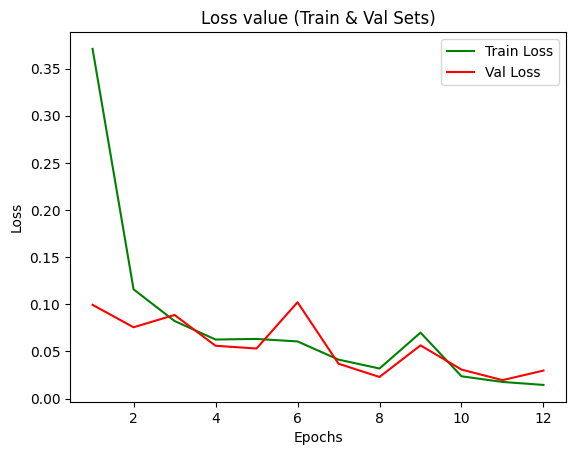

In [ ]:
loss_function = binary_model_history.history['loss']
val_loss_function = binary_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

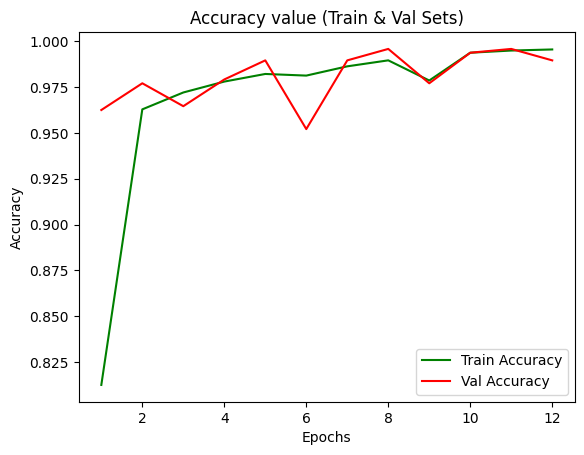

In [ ]:
accuracy_function = binary_model_history.history['accuracy']
val_accuracy_function = binary_model_history.history['val_accuracy']

epochs=range(1,len(loss_function)+1)

plt.title('Accuracy value (Train & Val Sets)')
plt.plot(epochs,accuracy_function,color='green',label='Train Accuracy')
plt.plot(epochs,val_accuracy_function,color='red',label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
preds = binary_model.predict(Test)

16/16 [==============================] - 209s 14s/step


In [ ]:
truth = Test.labels
binary_preds = np.argmax(preds, axis=1)

In [ ]:
print(classification_report(truth, binary_preds))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       645
           1       0.34      0.34      0.34       319

    accuracy                           0.56       964
   macro avg       0.51      0.51      0.51       964
weighted avg       0.56      0.56      0.56       964



Посмотрим, как модель предсказывает зараженные листья (класс 0) и здоровые (класс 1):

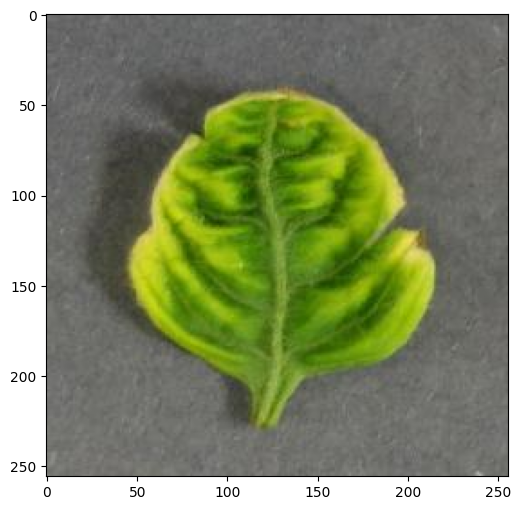

1/1 [==============================] - 0s 92ms/step
Предсказанный класс: [0]


In [ ]:
test_img = '/content/drive/MyDrive/binary/test/Tomato_Curl_Virus/02affd71-1fe6-48f7-bef4-3d5a59ec7814___UF.GRC_YLCV_Lab 01517.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = binary_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

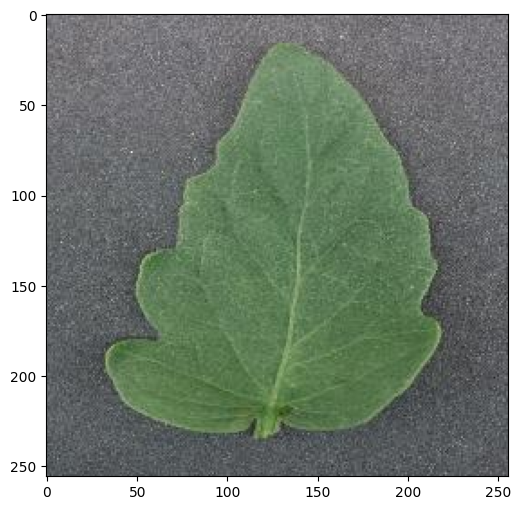

1/1 [==============================] - 0s 65ms/step
Предсказанный класс: [1]


In [ ]:
test_img = '/content/drive/MyDrive/binary/test/Tomato_Healthy/7f5c8018-c4c3-4471-aa30-defe910ea3d9___GH_HL Leaf 444.1.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = binary_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

### Задание №2
### Многоклассовый классификатор

Создаём папки для разделённых данных

In [ ]:
root = '/content/drive/MyDrive/multi'
os.makedirs(os.path.join(root, 'train'))
os.makedirs(os.path.join(root, 'valid'))
os.makedirs(os.path.join(root, 'test'))
os.makedirs(os.path.join(root, 'train/Tomato_Curl_Virus'))
os.makedirs(os.path.join(root, 'train/Tomato_Healthy'))
os.makedirs(os.path.join(root, 'train/Tomato_Septoria'))
os.makedirs(os.path.join(root, 'valid/Tomato_Curl_Virus'))
os.makedirs(os.path.join(root, 'valid/Tomato_Healthy'))
os.makedirs(os.path.join(root, 'valid/Tomato_Septoria'))
os.makedirs(os.path.join(root, 'test/Tomato_Curl_Virus'))
os.makedirs(os.path.join(root, 'test/Tomato_Healthy'))
os.makedirs(os.path.join(root, 'test/Tomato_Septoria'))

Разделим датасет на три части: тренировочную (70%), тестовую (20%) и валидационную (10%).

In [ ]:
split_train_size = .7
split_val_size = .1
split_test_size = .2

split_train_val_test(paths[0], '/content/drive/MyDrive/multi/train/Tomato_Curl_Virus',
                     '/content/drive/MyDrive/multi/valid/Tomato_Curl_Virus', '/content/drive/MyDrive/multi/test/Tomato_Curl_Virus',
                     split_train_size, split_val_size, split_test_size)
split_train_val_test(paths[1], '/content/drive/MyDrive/multi/train/Tomato_Healthy',
                     '/content/drive/MyDrive/multi/valid/Tomato_Healthy', '/content/drive/MyDrive/multi/test/Tomato_Healthy',
                     split_train_size, split_val_size, split_test_size)
split_train_val_test(paths[2], '/content/drive/MyDrive/multi/train/Tomato_Septoria',
                     '/content/drive/MyDrive/multi/valid/Tomato_Septoria', '/content/drive/MyDrive/multi/test/Tomato_Septoria',
                     split_train_size, split_val_size, split_test_size)
print('Train')
print(f"{len(os.listdir('/content/drive/MyDrive/multi/train/Tomato_Curl_Virus'))} изображений в {classes[0]}")
print(f"{len(os.listdir('/content/drive/MyDrive/multi/train/Tomato_Healthy'))} изображений в {classes[1]}")
print(f"{len(os.listdir('/content/drive/MyDrive/multi/train/Tomato_Septoria'))} изображений в {classes[2]}")
print('Valid')
print(f"{len(os.listdir('/content/drive/MyDrive/multi/valid/Tomato_Curl_Virus'))} изображений в {classes[0]}")
print(f"{len(os.listdir('/content/drive/MyDrive/multi/valid/Tomato_Healthy'))} изображений в {classes[1]}")
print(f"{len(os.listdir('/content/drive/MyDrive/multi/valid/Tomato_Septoria'))} изображений в {classes[2]}")
print('Test')
print(f"{len(os.listdir('/content/drive/MyDrive/multi/test/Tomato_Curl_Virus'))} изображений в {classes[0]}")
print(f"{len(os.listdir('/content/drive/MyDrive/multi/test/Tomato_Healthy'))} изображений в {classes[1]}")
print(f"{len(os.listdir('/content/drive/MyDrive/multi/test/Tomato_Septoria'))} изображений в {classes[2]}")

Train
2252 изображений в Tomato Curl Virus
1113 изображений в Tomato Healthy
1239 изображений в Tomato Septoria
Valid
321 изображений в Tomato Curl Virus
159 изображений в Tomato Healthy
177 изображений в Tomato Septoria
Test
645 изображений в Tomato Curl Virus
319 изображений в Tomato Healthy
355 изображений в Tomato Septoria


Генерация данных:

In [5]:
Train_base, Valid_base, Test_base = generate_train_val_test_base('/content/drive/MyDrive/multi/train', '/content/drive/MyDrive/multi/valid', '/content/drive/MyDrive/multi/test')

Found 4604 images belonging to 3 classes.
Found 657 images belonging to 3 classes.
Found 1319 images belonging to 3 classes.


### Создание моделей
#### Base Model

Возьмём предобученную на ImageNet модель ResNet50:

In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [25]:
for layer in base_model.layers:
    layer.trainable = False

Дообучим выбранную модель:

In [26]:
multi_base_model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
multi_base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 24702851 (94.23 MB)
Trainable params: 1115139 (4.25 MB)
Non-trainable params: 23587712 (89.98 MB)
________

In [27]:
multi_base_model.compile(keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Зададим число эпох, равное 20:

In [29]:
multi_base_model_history = multi_base_model.fit(Train_base, epochs=20, validation_data = Valid_base, callbacks = callbacks_list, verbose=1)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 1.0297 - accuracy: 0.5586
Epoch 1: val_accuracy improved from -inf to 0.68037, saving model to best_model.hdf5
72/72 [==============================] - 38s 418ms/step - loss: 1.0297 - accuracy: 0.5586 - val_loss: 0.8856 - val_accuracy: 0.6804
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.8060 - accuracy: 0.6614
Epoch 2: val_accuracy improved from 0.68037 to 0.73820, saving model to best_model.hdf5
72/72 [==============================] - 25s 341ms/step - loss: 0.8060 - accuracy: 0.6614 - val_loss: 0.7195 - val_accuracy: 0.7382
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.7133
Epoch 3: val_accuracy improved from 0.73820 to 0.76408, saving model to best_model.hdf5
72/72 [==============================] - 25s 349ms/step - loss: 0.6468 - accuracy: 0.7133 - val_loss: 0.5495 - val_accuracy: 0.7641
Epoch 4/20
72/72 [==============================] - ETA: 0s -

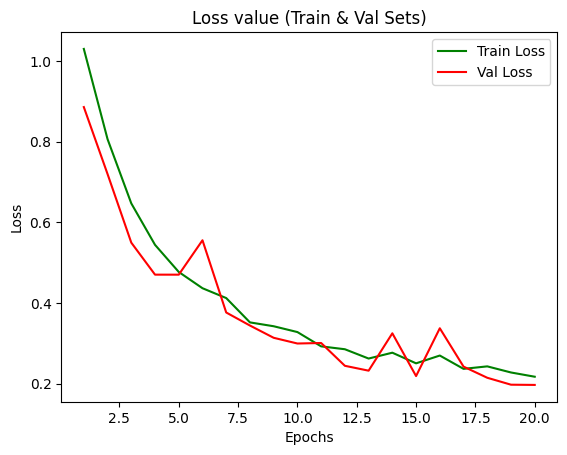

In [30]:
loss_function = multi_base_model_history.history['loss']
val_loss_function = multi_base_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

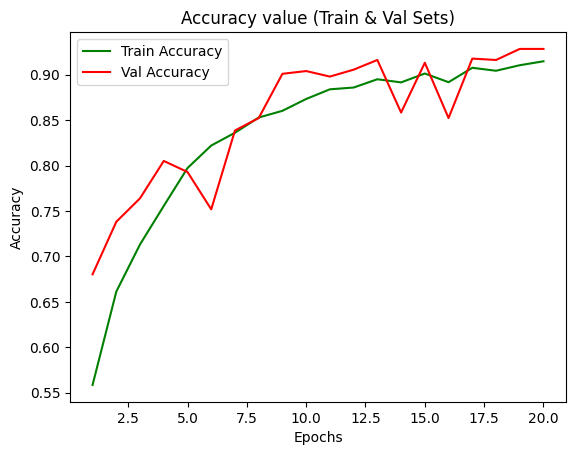

In [31]:
accuracy_function = multi_base_model_history.history['accuracy']
val_accuracy_function = multi_base_model_history.history['val_accuracy']

epochs=range(1,len(loss_function)+1)

plt.title('Accuracy value (Train & Val Sets)')
plt.plot(epochs,accuracy_function,color='green',label='Train Accuracy')
plt.plot(epochs,val_accuracy_function,color='red',label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
preds = multi_base_model.predict(Test_base)

21/21 [==============================] - 423s 21s/step


In [33]:
truth = Test_base.labels
multi_preds = np.argmax(preds, axis=1)

In [34]:
print(classification_report(truth, multi_preds))

              precision    recall  f1-score   support

           0       0.50      0.53      0.52       645
           1       0.23      0.23      0.23       319
           2       0.25      0.22      0.23       355

    accuracy                           0.38      1319
   macro avg       0.33      0.33      0.33      1319
weighted avg       0.37      0.38      0.37      1319



Посмотрим, как модель предсказывает изображения, относящиеся к разным классам:

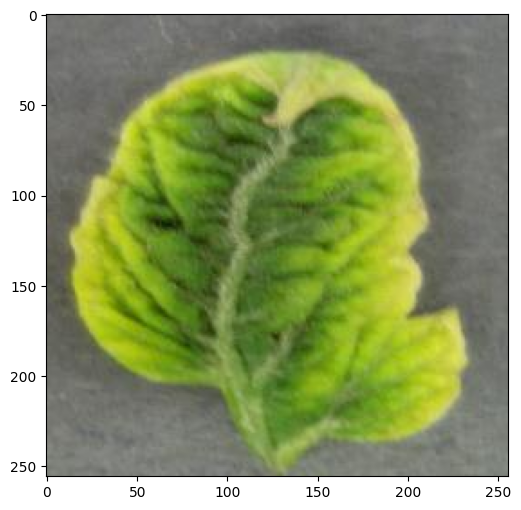

1/1 [==============================] - 3s 3s/step
Предсказанный класс: [0]


In [36]:
test_img = '/content/drive/MyDrive/multi/test/Tomato_Curl_Virus/758cc68d-9222-47b0-bf54-29f1d131ecdc___UF.GRC_YLCV_Lab 02593.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = multi_base_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

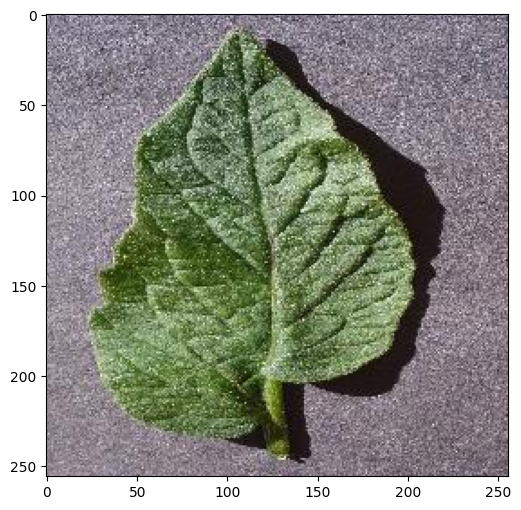

1/1 [==============================] - 0s 79ms/step
Предсказанный класс: [1]


In [37]:
test_img = '/content/drive/MyDrive/multi/test/Tomato_Healthy/beaa693e-fa0d-4bde-943a-0a834f251301___RS_HL 0290.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = multi_base_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

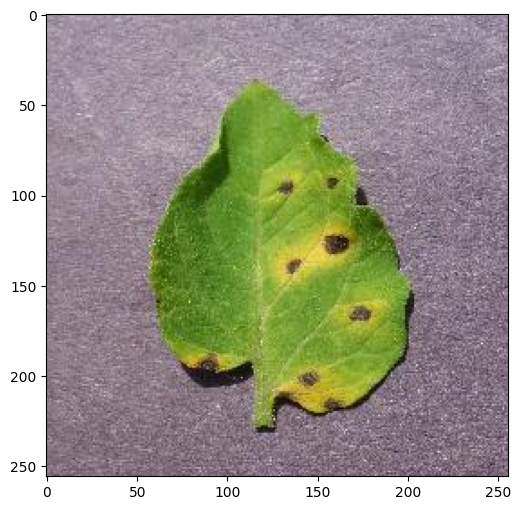

1/1 [==============================] - 0s 41ms/step
Предсказанный класс: [2]


In [39]:
test_img = '/content/drive/MyDrive/multi/test/Tomato_Septoria/481c8d4a-1bfa-48a7-9385-3352286bd765___Keller.St_CG 2036.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = multi_base_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

#### Second Model

Генерация данных с аугментацией:

In [40]:
Train, Valid, Test = generate_train_val_test('/content/drive/MyDrive/multi/train', '/content/drive/MyDrive/multi/valid', '/content/drive/MyDrive/multi/test')

Found 4604 images belonging to 3 classes.
Found 657 images belonging to 3 classes.
Found 1319 images belonging to 3 classes.


Создание второй модели. Дообучаем выбранную модель на новых данных:

In [41]:
multi_model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
multi_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dense_14 (Dense)            (None, 3)                 387       
                                                                 
Total params: 24702851 (94.23 MB)
Trainable params: 1115139 (4.25 MB)
Non-trainable params: 23587712 (89.98 MB)
________

In [42]:
multi_model.compile(keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Зададим число эпох, равное 20:

In [44]:
multi_model_history = multi_model.fit(Train, epochs=20, validation_data = Valid, callbacks = callbacks_list, verbose=1)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 1.0643 - accuracy: 0.5191
Epoch 1: val_accuracy improved from -inf to 0.56012, saving model to best_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 125s 2s/step - loss: 1.0643 - accuracy: 0.5191 - val_loss: 0.9366 - val_accuracy: 0.5601
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.8958 - accuracy: 0.6127
Epoch 2: val_accuracy improved from 0.56012 to 0.59361, saving model to best_model.hdf5
72/72 [==============================] - 118s 2s/step - loss: 0.8958 - accuracy: 0.6127 - val_loss: 0.8666 - val_accuracy: 0.5936
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.6590
Epoch 3: val_accuracy improved from 0.59361 to 0.69406, saving model to best_model.hdf5
72/72 [==============================] - 116s 2s/step - loss: 0.7900 - accuracy: 0.6590 - val_loss: 0.7362 - val_accuracy: 0.6941
Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.6685
Epoch 4: val_accuracy did not improve from 0.69406
72/72 [==============================] - 103s 1s/step - loss: 0.7411 - accuracy: 0.6685 - val_loss: 0

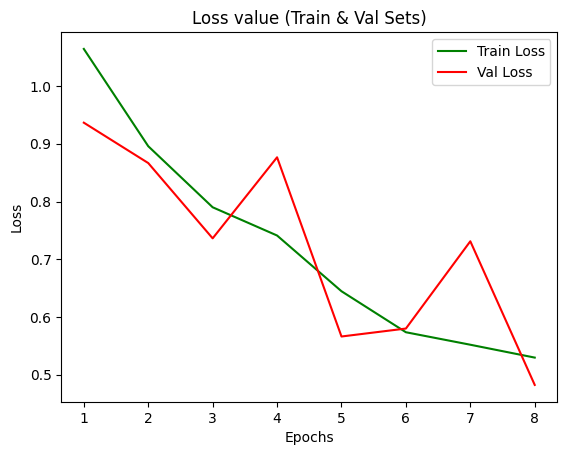

In [45]:
loss_function = multi_model_history.history['loss']
val_loss_function = multi_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

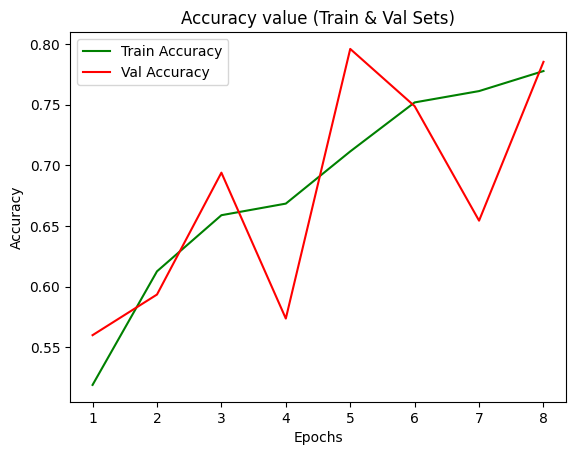

In [46]:
accuracy_function = multi_model_history.history['accuracy']
val_accuracy_function = multi_model_history.history['val_accuracy']

epochs=range(1,len(loss_function)+1)

plt.title('Accuracy value (Train & Val Sets)')
plt.plot(epochs,accuracy_function,color='green',label='Train Accuracy')
plt.plot(epochs,val_accuracy_function,color='red',label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
preds = multi_model.predict(Test)

21/21 [==============================] - 25s 1s/step


In [48]:
truth = Test.labels
multi_preds = np.argmax(preds, axis=1)

In [49]:
print(classification_report(truth, multi_preds))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48       645
           1       0.17      0.11      0.13       319
           2       0.26      0.33      0.29       355

    accuracy                           0.36      1319
   macro avg       0.30      0.31      0.30      1319
weighted avg       0.34      0.36      0.35      1319



Посмотрим, как модель предсказывает изображения, относящиеся к разным классам:

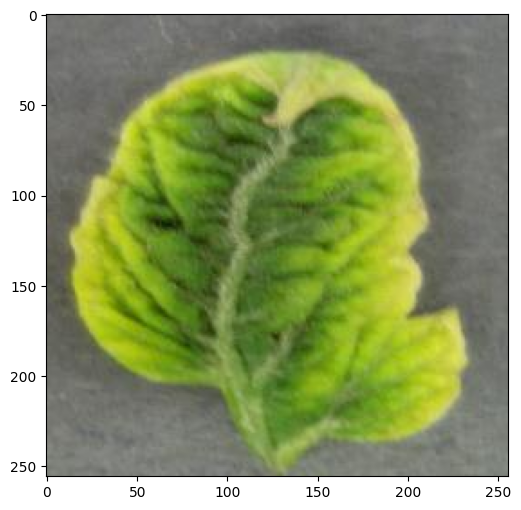

1/1 [==============================] - 1s 908ms/step
Предсказанный класс: [0]


In [50]:
test_img = '/content/drive/MyDrive/multi/test/Tomato_Curl_Virus/758cc68d-9222-47b0-bf54-29f1d131ecdc___UF.GRC_YLCV_Lab 02593.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = multi_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

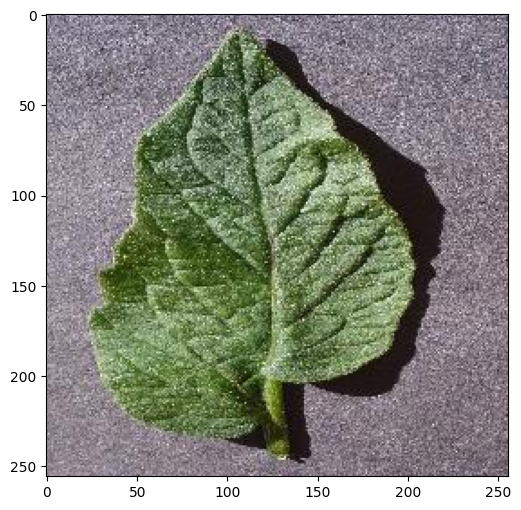

1/1 [==============================] - 0s 34ms/step
Предсказанный класс: [1]


In [51]:
test_img = '/content/drive/MyDrive/multi/test/Tomato_Healthy/beaa693e-fa0d-4bde-943a-0a834f251301___RS_HL 0290.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = multi_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

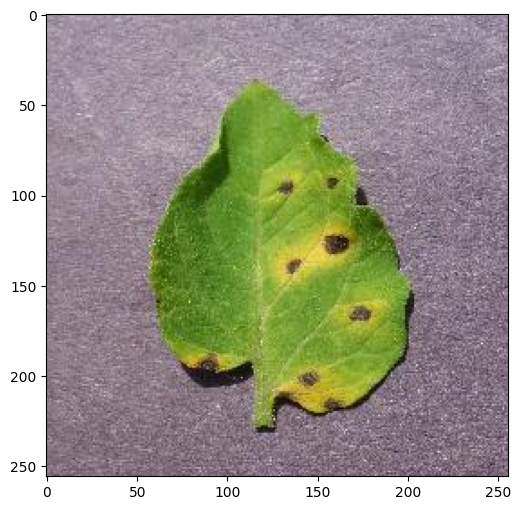

1/1 [==============================] - 0s 29ms/step
Предсказанный класс: [2]


In [52]:
test_img = '/content/drive/MyDrive/multi/test/Tomato_Septoria/481c8d4a-1bfa-48a7-9385-3352286bd765___Keller.St_CG 2036.JPG'

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(resized_img[0])
plt.show()

pred = multi_model.predict(resized_img)
print(f"Предсказанный класс: {np.argmax(pred, axis=1)}")

### Вывод

Набор данных содержал изображения листьев помидоров, разделённые на 3 класса: заражённые вирусом желтой курчавости, здоровые и больные септориозом. Для обучения бинарного классификатора использовались первые два класса. Датасет был разделен на 3 части: тренировочную (70%), тестовую (20%) и валидационную (10%). Для аугментации был использован ImageDataGenerator.

Для создания многоклассового классификатора была использована предобученная модель ResNet50.

Оценка качества классификаторов происходила с помощью classification_report.

Среди моделей бинарных классификаторов лучшие результаты показала модель, обучавшаяся на данных с аугментацией. Accuracy Base Model = 0.52, accuracy Second Model = 0.56.

Среди моделей многоклассовых классификаторов лучшие результаты показала модель, обучавшаяся на данных без аугментации. Accuracy Base Model = 0.38, accuracy Second Model = 0.36.

Лучше всего модели предсказывали класс изображений с листьями, заражёнными вирусом желтой курчавости, так как число данных в нём больше, чем в остальных классах.